## Mapping and validating lineaments

Matteo Niccoli, MyCarta

Calgary, Alberta, Canada

mycarta.wordpress.com

matteo@mycarta.ca

### Preliminaries - import Python dependencies

In [1]:
import numpy as np
import scipy as sp
from fatiando.gravmag import transform
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clr
from pylab import imread, imshow, gray, mean
from skimage.filters import threshold_otsu, rank, threshold_adaptive    # N.B.depending on the version of Python you are running
                                                                        # this may have to be "from skimage.filter import ..."
    
from skimage.morphology import disk, closing, opening, erosion, dilation, reconstruction, skeletonize, remove_small_objects
from skimage import img_as_uint, img_as_float
from skimage import io
from skimage import color

%matplotlib inline

### Preliminaries - import colormap

I will import cube1, one of my perceptually improved rainbows:

https://mycarta.wordpress.com/color-palettes/


In [2]:
# open colormap file, import raw RGB values
with open("cube1_0-1.csv", "r") as g:
  raw_data = g.read()

# split the raw data to get a list of strings
list_o_strings = raw_data.split() 

# Use a nested list comprehension to step over the list of strings, splitting each string on its commas
# and converting each element (which will still be a string) to a floating point number
list_o_lists = [[float(num) for num in string.split(',')] for string in list_o_strings]

# make a numpy array
cube1 = np.array(list_o_lists)

In [3]:
# Function to make MatplotLib colormap
def gen_cmap(name, array, start, end):
    b3 = array[:,2] # value of blue at sample n
    b2 = array[:,2] # value of blue at sample n
    b1 = np.linspace(start, end, len(b2)) # position of sample n - ranges from 0 to 1
    
    # Setting up columns for tuples
    g3 = array[:,1]
    g2 = array[:,1]
    g1 = np.linspace(start, end, len(g2))
    
    r3 = array[:,0]
    r2 = array[:,0]
    r1 = np.linspace(start, end, len(r2))
    
    # Creating tuples
    R = sorted(zip(r1,r2,r3))
    G = sorted(zip(g1,g2,g3))
    B = sorted(zip(b1,b2,b3))
    
    # Transposing
    RGB = zip(R,G,B)
    rgb = zip(*RGB)
    
    # Creating dictionary
    k = ['red', 'green', 'blue']
    Cube1 = dict(zip(k,rgb))
    
    return clr.LinearSegmentedColormap(name, Cube1)

In [4]:
my_cmap = gen_cmap('my_colormap',cube1, 1, 0)
my_cmap_r = gen_cmap('my_colormap_r', np.flipud(cube1), 1, 0)

### Introduction

Data enhancement can help to emphasize edges that correspond to contrasts in acoustic impedance, magnetic susceptibility, or bulk density. Such contrasts often indicate the presence of important geologic boundaries. Emphasizing the edges can help with mapping and interpretation of those boundaries.

Not all geologic boundaries are necessarily contrast boundaries that produce data edges, however. In addition, the location of interpretable edges is influenced by many factors, one of which is the enhancement method used. 

As an example of this, in Figure 2 of a post on MyCarta (Niccoli, 2012) I showed there's a qualitative correlation between occurrences of antimony mineralization in the southern Tuscany mining district and the distance from lineaments derived from the total horizontal derivative. 

Let's take a look at the it below (distance from lineaments increases as the color goes from blue to green, yellow, and then red).

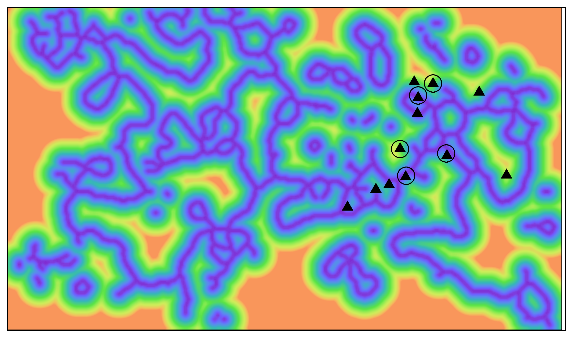

In [5]:
mycarta2=io.imread('https://mycarta.files.wordpress.com/2012/10/regio_distance_mineral_occurrences.png')

fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(mycarta2)
plt.show()

However, in Figure 1 of the same post I showed that lineaments derived using the maxima of the hyperbolic tilt angle (Cooper and Cowan, 2006) are offset systematically from those derived using the total horizontal derivative.

Let's take a look at the it below: in this case Bouguer gravity values increase as the color goes from blue to green, yellow, and then red; white polygons are basement outcrops.

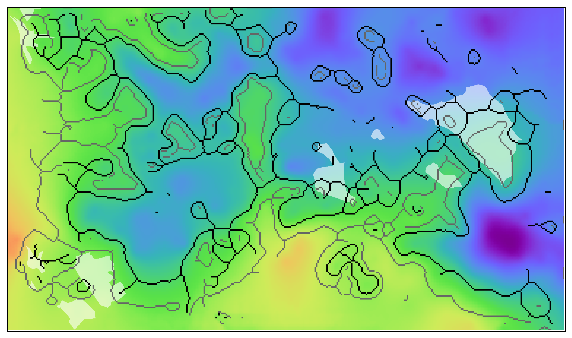

In [6]:
mycarta1=io.imread('https://mycarta.files.wordpress.com/2012/02/final-061.png')

fig = plt.figure(figsize=(10, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(mycarta1)
plt.show()

The lineaments from the total horizontal derivative are in black, those from the maxima of hyperbolic tilt angle are in gray.

This is how I produced the lineament overlays:  first I calculated the total horizontal derivative and the hyperbolic tilt angle (at the time I used Matlab code accompanying Cooper and Cowan's paper); then I found the maxima to use as overlay layers to go on top of the original data.

The result is similar to Figure 3e in Cooper and Cowan, but I refined the maxima result by reducing them to 1-pixel-wide lines (using a scheletonization, or thinning algorithm).

So, to go back to the initial point, which lineaments should be used?

The only way to know with confidence the location of density contrast edges (as a proxy for geological contacts) would be to use gravity forward models, or even 3D gravity inversion, ideally constrained by all available independent data sources ((magnetic or induced-polarization profiles, exploratory drilling data, reflection seismic interpretations, and so on).

The next best approach is to use edges from a number of independent gravity data enhancements that collocate.

Cooper and Cowan (2006) demonstrate that no single-edge detector method is a perfect geologic-contact mapper. Citing Pilkington and Keating (2004) they conclude that the best approach is to use “collocated solutions from different methods providing increased confidence in the reliability of a given contact location.

In the remainder of this Notebook, I show how to (1) create a full suite of derivative-based enhanced gravity maps, (2) extract and refine lineaments to map edges, and (3) combine them into a single collocation map to increase confidence in the edge locations.

### Part 1a - import grids of Bouguer gravity and coordinates, then calculate derivatives

The data for this tutorial is from a survey acquired with Michele Di Filippo in the Monti Romani of the southern Tuscany mining district, as part of my degree in Geology at the University of Rome, La Sapienza (Niccoli, 2000). 

https://www.researchgate.net/profile/M_Filippo

https://www.researchgate.net/profile/Matteo_Niccoli2

The raw measurements from 93 stations were reduced with a standard workflow to Bouguer gravity, and then interpolated to obtain a square grid of 8 km by 8 km; the grid node spacing was 100 m.

A regional trend was subtracted from the gridded Bouguer data to remove the effects of deeper, regional sources. 

We now import the output grid (residual Bouguer) from this latter step and display it. You can uncomment the last line to save the figure as a PNG image file.

(81, 81)


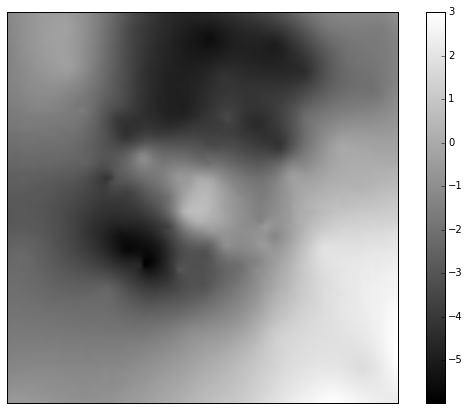

In [7]:
data = np.loadtxt('continued.txt') # import Bouguer gravity residual map
print data.shape

vmin=data.min()
vmax=data.max()

fig = plt.figure(figsize=(10,7))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(data, cmap='gray', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

#fig.savefig('data.png', dpi=200, bbox_inches='tight', pad_inches=0)

A number of features are seen in this map: there is a high in the southeastern quadrant of about 3.0 mGal corresponding to the location of a large basement outcrop in this area; then a northwest-southeast elongated high of about 0.5 mGal in the center bound by lows on both the southwest and northeast; finally a local high in the northwestern quadrant of about 0.5 mGal. This is a reflection of the tectonic history of the area: the compressional deformation of the Apennines caused doubling of the Paleozoic metamorphic basement, placing it in lateral contact with  less dense rocks of younger units (the Triassic-Oligocene Tuscany Nappe and the Cretaceous-Eocene Liguride Complex).

Next we import X and Y coordinate grids. These grids are necessary for the  calculation of derivatives and they have the correct spacing; however, since the data is from an unpublished thesis, the values have been normalized to the intervals 0-1 km.

In [8]:
xc = np.loadtxt('xc.txt')
yc = np.loadtxt('yc.txt')

The block below performs the calculation of the derviatives, dx, dy, and dz, using Fatiando a Terra.

Reference: Uieda et al. 2014

In [9]:
gauss = sp.ndimage.filters.gaussian_filter(data,1.) # apply mild smoothing

d = gauss.ravel() # rearrange data, X, and Y from 2D arrays to 1D arrays

y = xc.ravel() # x, y are switched because x in Fatiando is North-South. 
x = yc.ravel() # If we wanted to plot the data using coordinates we'd have to pass it, as , for example: contourf(y, x, ...)

xderiv = transform.derivx(x, y, d, data.shape) # calculate derivatives using Fatiando a Terra 
yderiv = transform.derivy(x, y, d, data.shape) 
zderiv = transform.derivz(x, y, d, data.shape)

xderiv2D = np.reshape(xderiv, (81, 81)) # reshape output arrays back to 2D
yderiv2D = np.reshape(yderiv, (81, 81))
zderiv2D = np.reshape(zderiv, (81, 81))

dx = xderiv2D # rename for convenience
dy = yderiv2D
dz = zderiv2D

Let's take a look at these derivatives. Again, you can uncomment the last line to save the figure as a PNG image file.

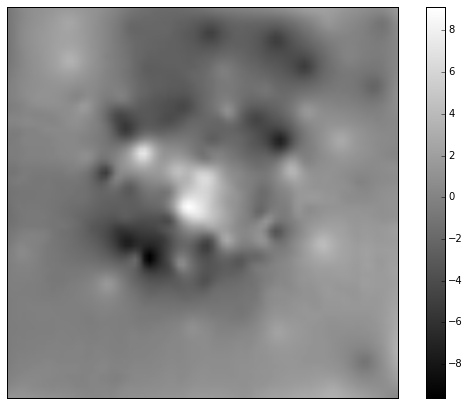

In [10]:
fig = plt.figure(figsize=(10,7))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

# gdz = sp.signal.medfilt2d(dz,3) # uncomment to apply very mild smoothing to remove a bit of station footprint

plt.imshow(dz, cmap='gray')
# plt.imshow(gdz, cmap='gray')

plt.colorbar()
plt.show()

#fig.savefig('dz.png', dpi=200, bbox_inches='tight', pad_inches=0)

[]

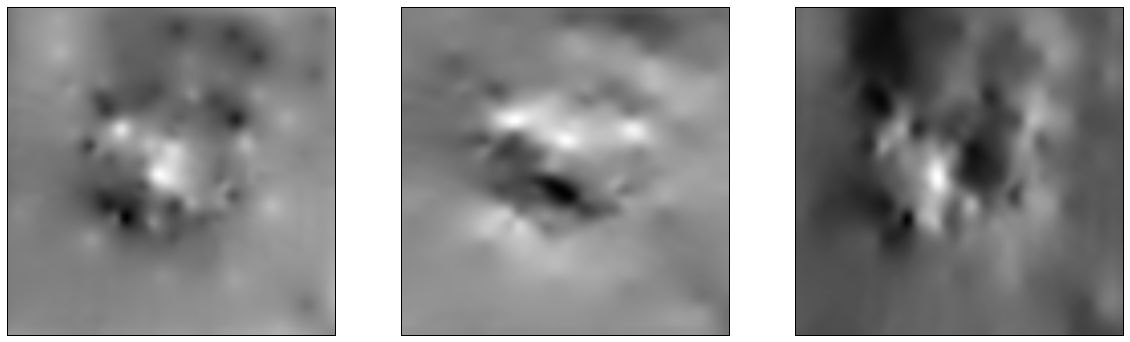

In [11]:
fig = plt.figure(figsize=(20, 10)) # all three derivatives in one plot

ax3 = fig.add_subplot(1, 3, 1)
imshow(dz, cmap='gray')
ax3.set_xticks([])
ax3.set_yticks([])

ax4 = fig.add_subplot(1, 3, 2)
imshow(dx, cmap='gray')
ax4.set_xticks([])
ax4.set_yticks([])

ax5 = fig.add_subplot(1, 3, 3)
imshow(dy, cmap='gray')
ax5.set_xticks([])
ax5.set_yticks([])


### Part 1b - calculate data enhancements to use as edge detectors

Some of these enhancements will display maxima over density contrasts (contacts), whereas others change from negative to positive so that their zero contour will maps the contrasts. More details on these enhancements can be found in Pilkington and Keating, 2004 and 2010, and in Cooper and Cowan, 2006; these are also must-read papers on how to determine their redundancy (and why they are redundant) prior to using them as edge detectors.

#### Calculating and displaying the total horizontal derivative

Reference: Cooper and Cowan, 2006

In [12]:
tdx=np.sqrt(dx*dx + dy*dy) # calcualate total horizontal derivative

tdx01=(tdx-tdx.min())/(tdx.max()-tdx.min()) # rescale values to the range 0-1
tdxmin= tdx01.mean() - 2 * tdx01.std()      # calculate mean and standard deviation
tdxmax= tdx01.mean() + 2 * tdx01.std()      # to help wit hthe display of the data

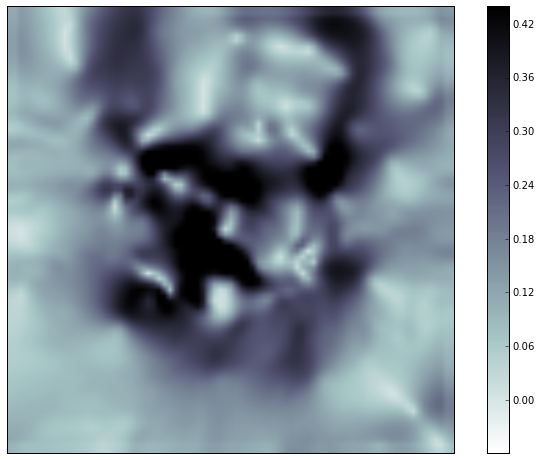

In [13]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(tdx01, cmap='bone_r', vmin = tdxmin, vmax = tdxmax) # display the total horizontal derivative
plt.colorbar()
plt.show()

#### Calculating the tilt angle, total horizontal derivative of tilt angle, and theta map

#### Tilt angle

Reference: Miller and Singh, 1994

#### THDR, total horizontal derivative of tilt angle

Reference: Verduzco et al., 2004

#### Theta map

Reference: Wijns et al., 2005

In [14]:
tilt=np.arctan(dz/tdx) # calculate the tilt angle
gtilt = sp.ndimage.filters.gaussian_filter(tilt,1.) # apply minor gaussian smoothing

In [15]:
dxt,dyt = np.gradient(gtilt, 1, 1) # calculate THDR, total horizontal derivative of (smoothed) tilt angle
thdr=np.sqrt(dxt*dxt + dyt*dyt)

thdrmin= thdr.mean() - 2 * thdr.std()
thdrmax= thdr.mean() + 2 * thdr.std()

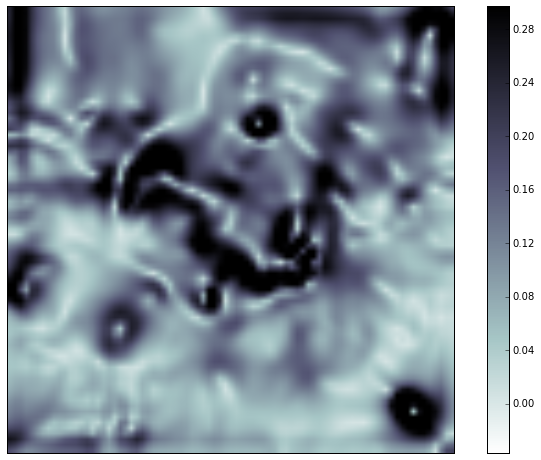

In [16]:
fig = plt.figure(figsize=(12, 8)) # display THDR

ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xticks([])
ax1.set_yticks([])

plt.imshow(thdr,cmap='bone_r', vmin=thdrmin, vmax=thdrmax)
plt.colorbar()
plt.show()

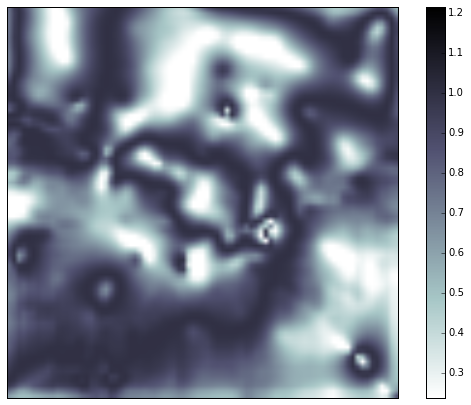

In [17]:
theta=tdx/(np.sqrt(dx*dx + dy*dy +dz*dz)) # calculate theta map (e.g. cos(theta))
                                          # by dividing the total horizontal derivative by the analytical signal

thetamin= theta.mean() - 2 * theta.std()
thetamax= theta.mean() + 2 * theta.std()

# plot it

fig = plt.figure(figsize=(10,7))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(theta,cmap='bone_r', vmin=thetamin, vmax=thetamax)
plt.colorbar()
plt.show()

# fig.savefig('theta.png', dpi=200)

That is a very nice, continuous edge.

#### NSTD, normalized standard deviation of data

Cooper and D. R. Cowan, 2008

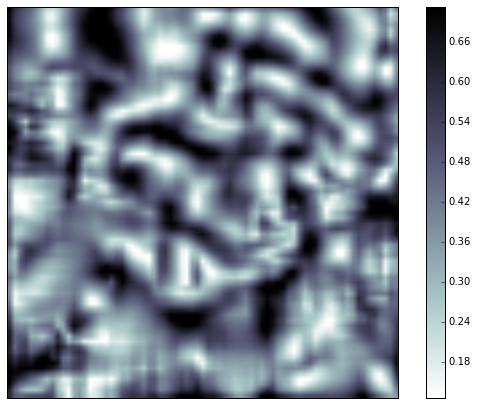

In [18]:
nstd = np.loadtxt('nstd.txt') # import NSTD calculated using Matlab code from Cooper and Cowan.

nstdmin= nstd.mean() - 2 * nstd.std()
nstdmax= nstd.mean() + 2 * nstd.std()

fig = plt.figure(figsize=(10, 7)) # plot it 

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(nstd, cmap='bone_r', vmin=nstdmin, vmax=nstdmax)
plt.colorbar()
plt.show()


Notice that NSTD has enhanced more subtle gradients in the original data but also the noise.

#### Calculating the normalized total horizontal derivative, TDXN

Reference: Cooper and Cowan, 2006

(notice that in the paper the authors use fxtot for the total horizontal derivative, and TDX for the normalized total horizontal derivative; I've adopted the alternative TDX, and TDXN, respectively.

With TDXN, the total horizontal derivative is normalized using the vertical derivative, resulting in an enhancement that performs well on both shallow and deep sources, which is demonstrated in the paper using synthetic data. The idea for this normalized filter comes from the observation that edges are characterized by maxima in the  total horizontal derivative, and zeros in the vertical derivative, hence dividing them would be a superior edge detector (Gordon Cooper, personal communication).

Let's take a look first at the zero contours of dz.

In [19]:
z = (plt.contour(dz, [0.0])) # get the zero contours for dz
plt.close() # prevent Matplotlib from displaying the contours automatically (with default settings)

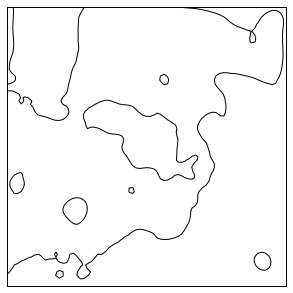

In [20]:
fig = plt.subplots(figsize=[5,5])
cmp = cm.get_cmap('bone', 2)
plt.contour(dz, [0.0], cmap=cmp, interpolation='none', origin="upper")  # plot with custom settings
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

That looks promising. Now let's calculate TDXN.

In [21]:
tdxn=np.real(np.arctan(tdx/np.absolute(dz))) # calculate normalized total horizontal derivative
tdxn = sp.signal.medfilt2d(tdxn,3) # apply very mild smoothing

tdxn01=(tdxn-tdxn.min())/(tdxn.max()-tdxn.min()) # rescale values to 0-1 range
tdxnmin= tdxn01.mean() - 2 * tdxn01.std()        # these help with display
tdxnmax= tdxn01.mean() + 2 * tdxn01.std()

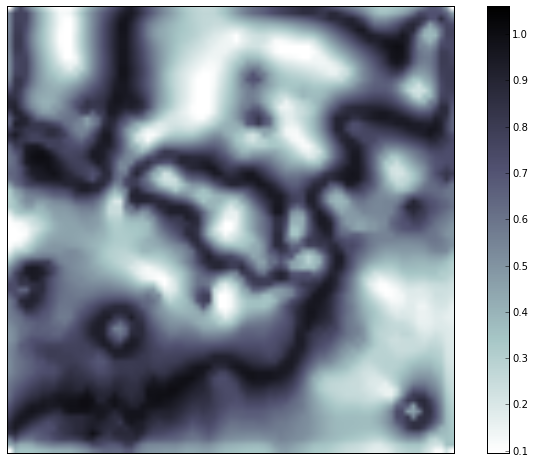

In [22]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(tdxn01,cmap='bone_r', vmin = tdxnmin, vmax=tdxnmax)
plt.colorbar()
plt.show()

This is a nice, continuous edge. It is very similar to the Theta map, or cos(theta).

#### An example of how to use these enhanced maps: draping the TDXN over the original data

In part 2 we move on to extract lineaments from the data enhancements. However, one way to use the enhancements already is to combine them with the original data. Let's look at one example.

Below is a version of the Bouguer residual data colored using the cube1 colormap. 

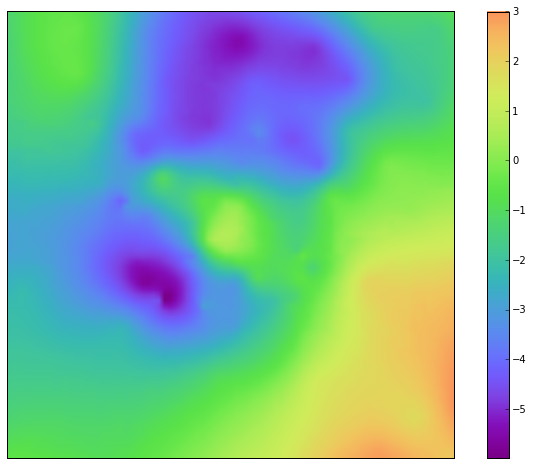

In [23]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(data,cmap=my_cmap_r)
plt.colorbar()
plt.show()

We can drape the TDXN result over this map of the original data.

If we replace the Value channel in the HSV color image of the data with the TDXN  map we will get a map of the data that has both a pseudo-relief feel, and displays the enhanced edges as maxima in the TDXN.

First we need to normalize the data, then we pass it through the colormap to make an image array.

In [24]:
data_n=(data-data.min())/(data.max()-data.min())
img_array = plt.get_cmap(my_cmap_r)(data_n)

Now we can do the replacement of the Value channel, and finally we plot the relief shaded data... voilà.

In [25]:
hsv = clr.rgb_to_hsv(img_array[:, :, :3])
hsv[:, :, 2] = 1-tdxn01
rgb = clr.hsv_to_rgb(hsv)

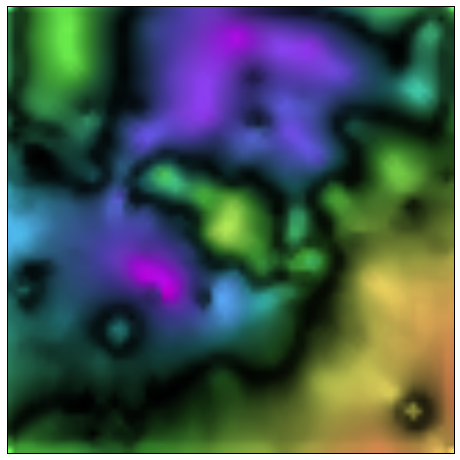

In [26]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(1, 1, 1)
ax1.set_xticks([])
ax1.set_yticks([])

plt.imshow(rgb)
plt.show()

We could also try to plot the zero contour of dz on top of the original data.
We grab one contour first as a test.

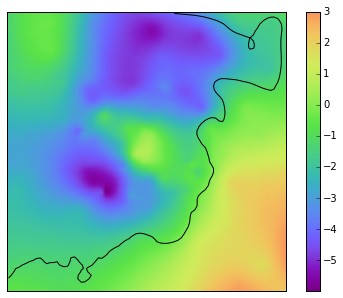

In [27]:
line = z.collections[0].get_paths()[2].vertices  # selected 2nd by trial and error to get the longest contour segment

fig = plt.figure(figsize=(7, 5))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(data,cmap=my_cmap_r, origin="upper")
plt.plot(line[:,0], line[:,1], 'k-')

plt.colorbar()
plt.show()

Now we iterate over get_paths() to get all zero contour segments on top of the data

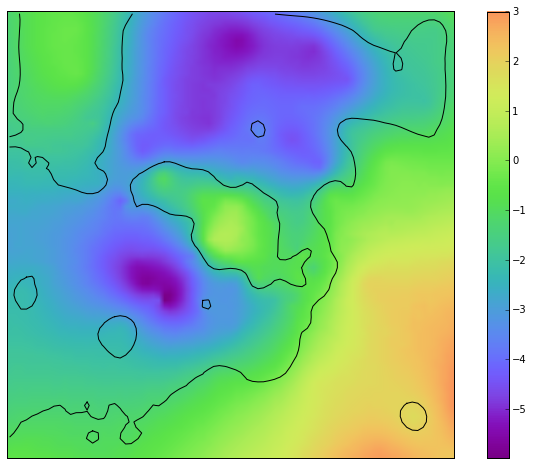

In [28]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(data,cmap=my_cmap_r, origin="upper")

for collection in z.collections:
    paths = collection.get_paths()
    for path in paths:
        line=(path.vertices)
        plt.plot(line[:,0], line[:,1], 'k-')
plt.colorbar()
plt.show()

As single edge result, this looks very nice. Better than draping TDXN over the data as Value channel. 

### Part 2 - extrat lineaments from enhanced maps


The first step is to apply a threshold to convert the enhanced maps to binary images, with the following convention:
ones = white = foreground (edges)
zeros= black = background

One way to do this automatically is to use global Otsu thresholding, which calculates the optimal value to segment the image into two classes by maximizing the variance between pixels. 

http://scikit-image.org/docs/dev/auto_examples/plot_otsu.html

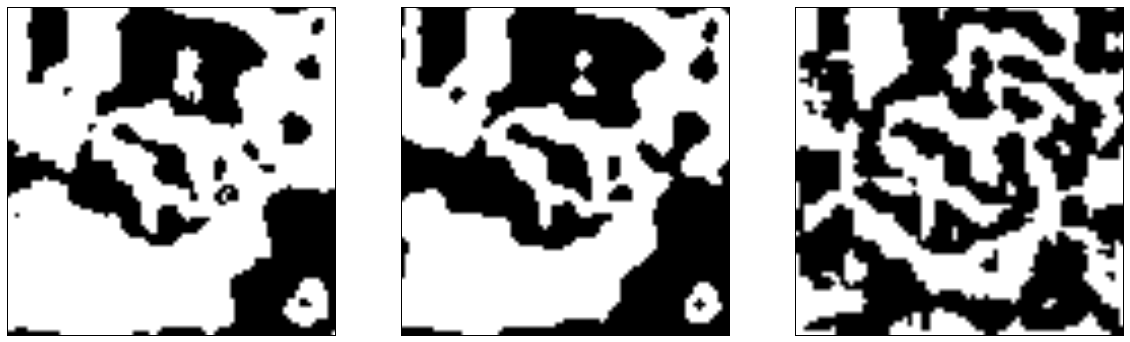

In [29]:
# theta map
thresh_th = threshold_otsu(theta)
binary_th = theta > thresh_th

# normalized total horizontal derivative
thresh_td = threshold_otsu(tdxn01)
binary_td = tdxn01 > thresh_td

# nstd
thresh_ns = threshold_otsu(nstd)
binary_ns = nstd > thresh_ns


# plot them 
fig = plt.figure(figsize=(20, 7))

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_xticks([])
ax1.set_yticks([])
imshow(binary_th, cmap=plt.cm.gray)

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_xticks([])
ax2.set_yticks([])
imshow(binary_td, cmap=plt.cm.gray)

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_xticks([])
ax3.set_yticks([])
imshow(binary_ns, cmap=plt.cm.gray)

The global Otsu method separated high amplitudes from low amplitudes but did not isolate the maxima (which really should be expected, based on its definition).

A better approach is to use manual threshold with a scalar value. The value is selected for each map after trial and error.

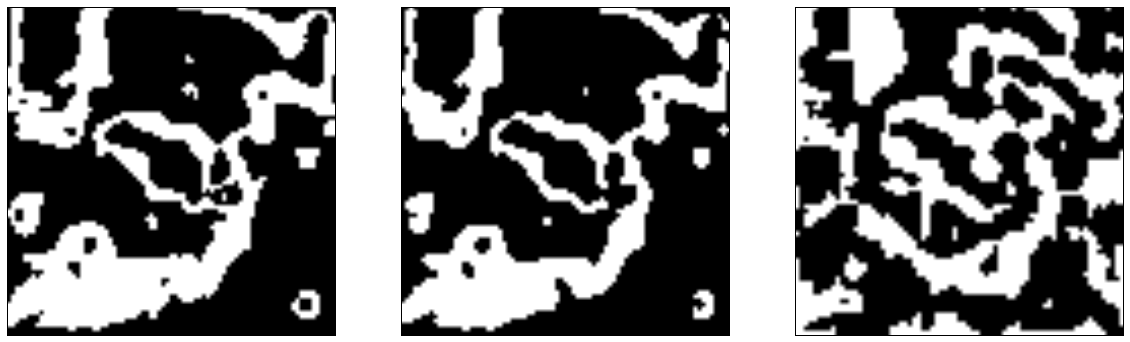

In [30]:
# theta map
binary_th = color.rgb2gray(theta) > 0.9

# normalized total horizontal derivative
binary_td = color.rgb2gray(tdxn01) > 0.75

# nstd
binary_ns = color.rgb2gray(nstd) > 0.45


# plot them 
fig = plt.figure(figsize=(20, 7))

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_xticks([])
ax1.set_yticks([])
imshow(binary_th, cmap=plt.cm.gray)

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_xticks([])
ax2.set_yticks([])
imshow(binary_td, cmap=plt.cm.gray)

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_xticks([])
ax3.set_yticks([])
imshow(binary_ns, cmap=plt.cm.gray)


That looks much better. 

Now we can use a variety of techniques to further enhance these binary images. With the first one (labeling) we identify and remove all white objects smaller than a specific size. This is often part of an image segmentation workflow, e.g.:

http://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html



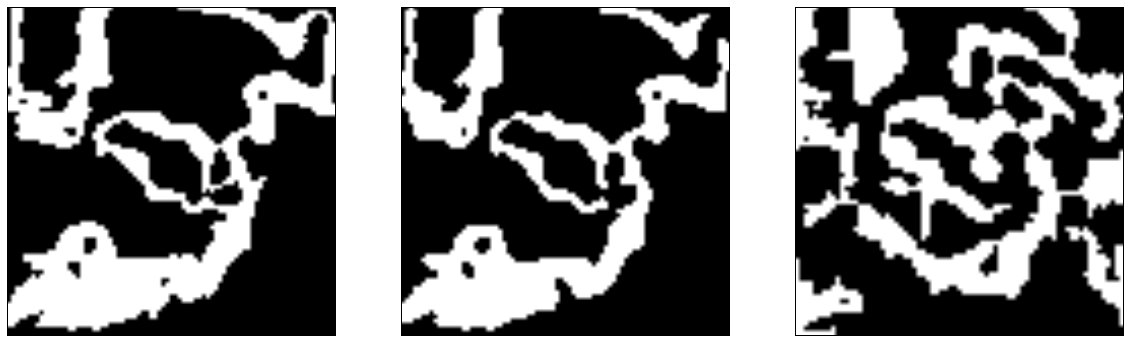

In [31]:
# theta map
label_objects_th, nb_labels_th = sp.ndimage.label(binary_th) # label all white objects ( made up of ones)
sizes_th = np.bincount(label_objects_th.ravel())             # calculate every labeled object's size
mask_sizes_th = sizes_th > 75                                # mask with zeros all objects smaller than
mask_sizes_th[0] = 0                                         # the given size
binary_cleaned_th = mask_sizes_th[label_objects_th]

# normalized total horizontal derivative
label_objects_td, nb_labels_td = sp.ndimage.label(binary_td)
sizes_td = np.bincount(label_objects_td.ravel())
mask_sizes_td = sizes_td > 75
mask_sizes_td[0] = 0
binary_cleaned_td = mask_sizes_td[label_objects_td]

# nstd
label_objects_ns, nb_labels_ns = sp.ndimage.label(binary_ns)
sizes_ns = np.bincount(label_objects_ns.ravel())
mask_sizes_ns = sizes_ns > 75
mask_sizes_ns[0] = 0
binary_cleaned_ns = mask_sizes_ns[label_objects_ns]


# plot 
fig = plt.figure(figsize=(20, 7))

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_xticks([])
ax1.set_yticks([])
imshow(binary_cleaned_th, cmap=plt.cm.gray)

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_xticks([])
ax2.set_yticks([])
imshow(binary_cleaned_td, cmap=plt.cm.gray)

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_xticks([])
ax3.set_yticks([])
imshow(binary_cleaned_ns, cmap=plt.cm.gray)

We will now use some morphological operations from the Python image processing module, scikit-image. First, with closing (a dilation followed by an erosion), we remove the smaller dark spots in the binary images using a disk-shaped structuring element.

For reference on Python morphological operations using scikit-image see van der Walt, et al, 2014.

For a gallery of worked examples, see: 

http://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html

Excellent extra reading on morphological operations - Morphology with Imagemagik:

http://www.imagemagick.org/Usage/morphology


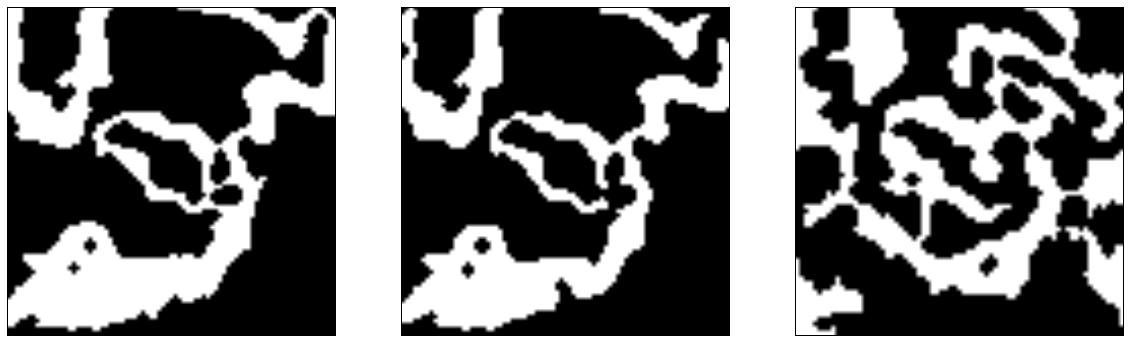

In [32]:
selem = disk(1)

closed_th = closing(binary_cleaned_th, selem)
closed_td = closing(binary_cleaned_td, selem)
closed_ns = closing(binary_cleaned_ns, selem)

eroded_th = erosion(closed_th, selem)
eroded_td = erosion(closed_td, selem)
eroded_ns = erosion(closed_ns, selem)

# plot them 
fig = plt.figure(figsize=(20, 7))

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_xticks([])
ax1.set_yticks([])
imshow(closed_th, cmap=plt.cm.gray)

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_xticks([])
ax2.set_yticks([])
imshow(closed_td, cmap=plt.cm.gray)

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_xticks([])
ax3.set_yticks([])
imshow(closed_ns, cmap=plt.cm.gray)


In the next block, we extract lineaments, using skeletonization.

http://scikit-image.org/docs/dev/auto_examples/plot_skeleton.html

http://scikit-image.org/docs/dev/auto_examples/plot_medial_transform.html

We will compare the skeleton on the initial binary, cleaned binary, closed binary.

In [33]:
skeleton_th=skeletonize(binary_th)
skeleton_cleaned_th=skeletonize(binary_cleaned_th)
skeleton_cleaned_th1=skeletonize(closed_th)

skeleton_td=skeletonize(binary_td)
skeleton_cleaned_td=skeletonize(binary_cleaned_td)
skeleton_cleaned_td1=skeletonize(closed_td)

skeleton_ns=skeletonize(binary_ns)
skeleton_cleaned_ns=skeletonize(binary_cleaned_ns)
skeleton_cleaned_ns1=skeletonize(closed_ns)
skeleton_cleaned_ns1=np.pad(skeleton_cleaned_ns1, 4, 'minimum')  # padding the Matlab NSTD array since it is smaller

We do the comparison for the normalized total horizontal derivative.

[]

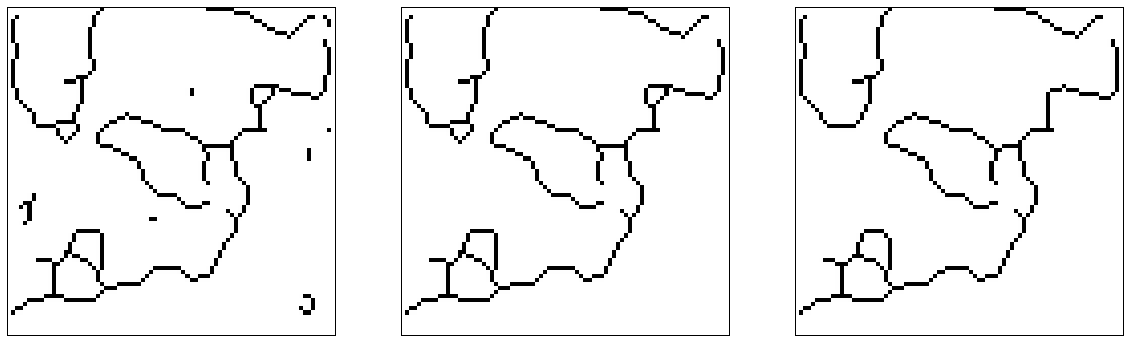

In [34]:
fig = plt.figure(figsize=(20, 7))

ax4 = fig.add_subplot(1, 3, 1)
imshow(skeleton_td, cmap='bone_r', interpolation='none')

ax5 = fig.add_subplot(1, 3, 2)
imshow(skeleton_cleaned_td, cmap='bone_r', interpolation='none')

ax6 = fig.add_subplot(1, 3, 3)
imshow(skeleton_cleaned_td1, cmap='bone_r', interpolation='none')

ax4.set_xticks([])
ax4.set_yticks([])

ax5.set_xticks([])
ax5.set_yticks([])

ax6.set_xticks([])
ax6.set_yticks([])

And now we plot the skeletons on the closed binary for normalized total horizontal derivative, thdr, and nstd.

[]

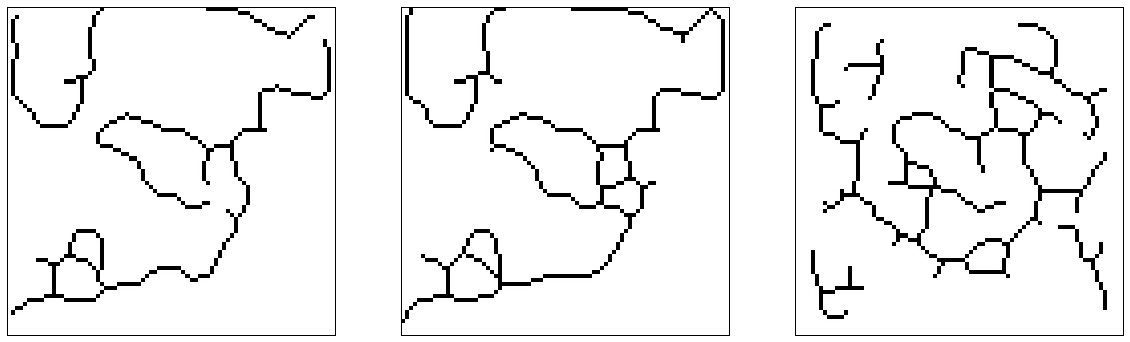

In [35]:
fig = plt.figure(figsize=(20, 7))

ax4 = fig.add_subplot(1, 3, 1)
imshow(skeleton_cleaned_td1, cmap='bone_r', interpolation='none')

ax5 = fig.add_subplot(1, 3, 2)
imshow(skeleton_cleaned_th1, cmap='bone_r', interpolation='none')

ax6 = fig.add_subplot(1, 3, 3)
imshow(skeleton_cleaned_ns1, cmap='bone_r', interpolation='none')

ax4.set_xticks([])
ax4.set_yticks([])

ax5.set_xticks([])
ax5.set_yticks([])

ax6.set_xticks([])
ax6.set_yticks([])

According to Pilkington and Keating, 2010, THETA map (maxima) and TDXN (maxima) are equivalent (and so is the zero contour of dz), so to make the edge collocation map, I decided to keep TDXN only, and to add THDR.

I will try a different method to binarize THDR: I will export it as an image, then re-import it applying a threshold. Uncomment last line to save the figure without white space around it and the edge removed.

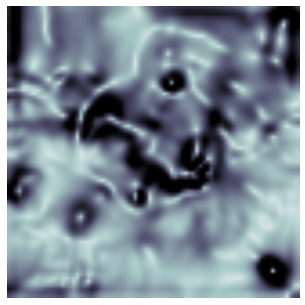

In [36]:
w = 4.05 # define figure size as a 20th of the size of the array
h = 4.05

cmp = cm.get_cmap('bone', 2) # grab a two-color colormap

fig = plt.figure(frameon=False)
fig.set_size_inches(w,h)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(thdr,cmap='bone_r', vmin=thdrmin, vmax=thdrmax)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

# fig.savefig('THDR.png', dpi=20) # export at 20 dpi to get an image of exactly the same size of the array

Import back and apply threshold (selected by trial and error the value that best isolates the maxima)

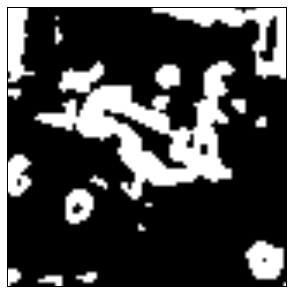

In [37]:
inTHDR=io.imread('THDR.png')       # import back THDR image
binary_thdr = ~(color.rgb2gray(inTHDR) > 0.34)*1.0  # binarize it; the result of rgb2gray is logical (True, False)
                                                    # hence the multiplication by 1.0
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(binary_thdr, cmap='bone')
plt.show()

Now we can clean this edge up as we have done previously for the other edges, by removing the small white objects, and then closing to remove small black objects.

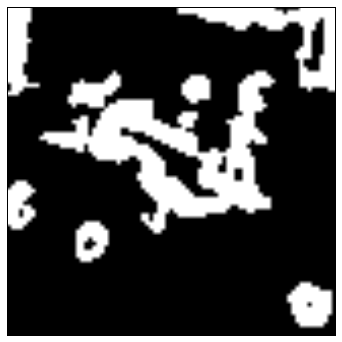

In [38]:
label_objects_thdr1, nb_labels_thdr1 = sp.ndimage.label(binary_thdr) # clean up small objects thdr
sizes_thdr1 = np.bincount(label_objects_thdr1.ravel())
mask_sizes_thdr1 = sizes_thdr1 > 15
mask_sizes_thdr1[0] = 0
binary_cleaned_thdr1 = mask_sizes_thdr1[label_objects_thdr1]

fig = plt.figure(figsize=(20, 7))
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_xticks([])
ax1.set_yticks([])
imshow(binary_cleaned_thdr1, cmap='bone')

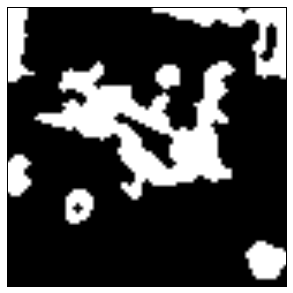

In [39]:
closed_thdr = closing(binary_cleaned_thdr1, selem)

# plot it 
fig = plt.figure(figsize=(5, 5))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(closed_thdr, cmap='bone')
plt.show()


Now we extract lineaments using again skeletonization.

[]

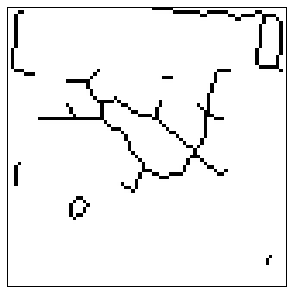

In [40]:
skeleton_cleaned_THDR=skeletonize(closed_thdr)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
imshow(skeleton_cleaned_THDR, cmap='bone_r',interpolation='none')
ax.set_xticks([])
ax.set_yticks([])

### Part 3 - make a lineament collocation map 


To make the lineament collocation map I first enlarge the skeletons a bit using dilation, so as to make the resulting lineaments  three-pixels wide, and then I sum them up. 

http://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html

In [41]:
selem2 = disk(1)
dilated_skeleton_td1 = dilation (skeleton_cleaned_td1, selem2)
dilated_skeleton_thdr1 = dilation (skeleton_cleaned_THDR, selem2)
dilated_skeleton_ns1 = dilation (skeleton_cleaned_ns1, selem2)

We have to convert these results from logical to binary.

In [42]:
dilated_skeleton_td1 = dilated_skeleton_td1*1.0
dilated_skeleton_thdr1 = dilated_skeleton_thdr1*1.0
dilated_skeleton_ns1 = dilated_skeleton_ns1*1.0

print np.amax(dilated_skeleton_td1), np.amin(dilated_skeleton_td1)
print np.amax(dilated_skeleton_thdr1), np.amin(dilated_skeleton_thdr1)
print np.amax(dilated_skeleton_ns1), np.amin(dilated_skeleton_ns1)

1.0 0.0
1.0 0.0
1.0 0.0


Let's take a look.

[]

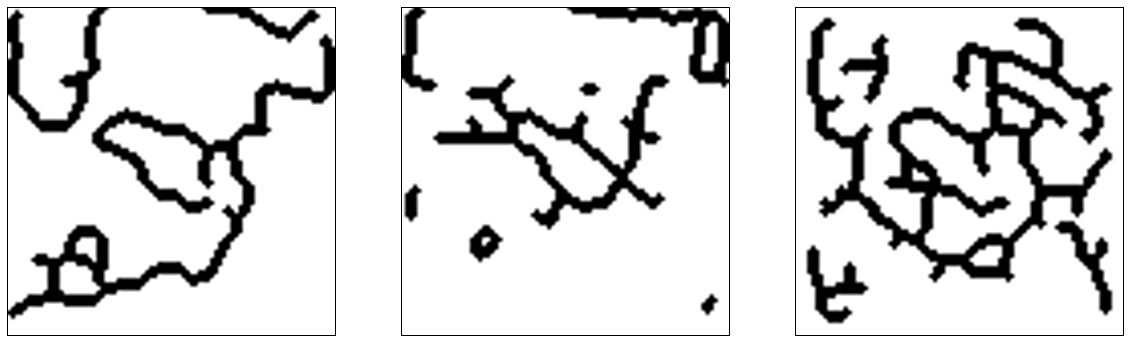

In [43]:
fig = plt.figure(figsize=(20, 8))

ax1 = fig.add_subplot(1, 3, 1)
imshow(dilated_skeleton_td1, cmap='bone_r',interpolation='spline16')
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(1, 3, 2)
imshow(dilated_skeleton_thdr1, cmap='bone_r',interpolation='spline16')
ax2.set_xticks([])
ax2.set_yticks([])

ax3 = fig.add_subplot(1, 3, 3)
imshow(dilated_skeleton_ns1, cmap='bone_r',interpolation='spline16')
ax3.set_xticks([])
ax3.set_yticks([])

Now we perform the summation.

In [44]:
collocation =  dilated_skeleton_thdr1 + dilated_skeleton_td1 + dilated_skeleton_ns1

In the next block I create a custom heated body colormap to display the collocation result.

In [45]:
ch = plt.get_cmap('afmhot')

# extract the colormap RGBA values at the 16 points
rgba = ch(np.arange(256))

# slice rgba to discard Alpha
rgb01= rgba[0:180,:3]

# setting up color arrays
r1 = rgb01[:, 0] # value of Red for the nth sample
g1 = rgb01[:, 1] # value of Green for the nth sample
b1 = rgb01[:, 2] # value of Blue for the nth sample

r2 = r1 # value of Red at the nth sample
r0 = np.linspace(0, 1, len(r1)) # position of the nth Red sample within the range 0 to 1

g2 = g1 # value of Green at the nth sample
g0 = np.linspace(0, 1, len(g1)) # position of the nth Green sample within the range 0 to 1

b2 = b1 # value of Blue at the nth sample
b0 = np.linspace(0, 1, len(b1)) # position of the nth Blue sample within the range 0 to 1

# creating lists
R = zip(r0, r1, r2)
G = zip(g0, g1, g2)
B = zip(b0, b1, b2)

# creating list of above lists and transposing
RGB = zip(R, G, B)
rgb = zip(*RGB)
#print rgb

# creating dictionary
k=['red', 'green', 'blue'] # makes list of keys
my_hot=dict(zip(k,rgb)) # makes a dictionary from list of keys and list of values
m_hot = clr.LinearSegmentedColormap('my_hot', my_hot)

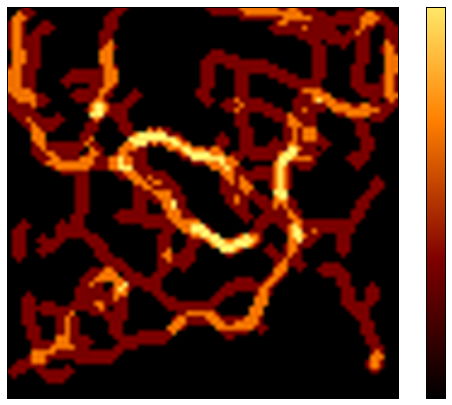

In [46]:
fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(collocation,cmap=m_hot, interpolation='spline16')
cb=plt.colorbar()
cb.set_ticks([]) # taking off the labels from the colormap to add custom ones in image editor

#fig.savefig('collocation_full.png', dpi=200, bbox_inches='tight', pad_inches=0)

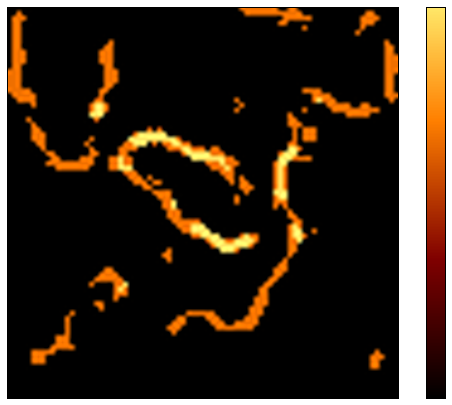

In [47]:
finalmap = np.ma.masked_where(collocation <2., collocation)
finalmap = finalmap.filled(0)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(finalmap,cmap=m_hot, vmax=3, vmin=0, interpolation='spline16')
cb = plt.colorbar()
cb.set_ticks([])

#fig.savefig('colocation.png', dpi=200, bbox_inches='tight', pad_inches=0)

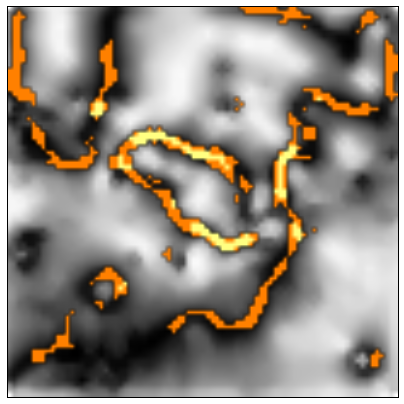

In [48]:
fig = plt.figure(figsize=(10, 7))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(tdxn,  cmap='Greys')
finalmap[finalmap==0] = np.nan
plt.imshow(finalmap, cmap='afmhot', vmin=0, vmax=4)
plt.show()


fig.savefig('tdxn_and_colocation.png', dpi=200, bbox_inches='tight', pad_inches=0)

### Discussion

For completeness, I include below Figure 3 from the paper. It shows (top and bottom panels) a 2.5D forward model along a profile from Niccoli (2000), to which I added in panel in the middle a collocation plot extracted along the same profile, yielding increased confidence in the location of geologic contacts in the model shown in the bottom panel.

Notice that this figure was not created in Python.

In this case, forward modeling had been carried out first and the work on edges and collocation afterward, to be used  as validation. The ideal strategy, however, would be to do the work on the edges and collocation first and then extract both along the desired profile and use them to place vertical boundaries between bodies of different density. These boundaries then could be modified based on geologic knowledge of the area and other controls (magnetic or induced-polarization profiles, exploratory drilling, and so forth). This technique also could be used to collocate lineaments derived from either reduced-to-pole magnetic data or seismic data (e.g., Russell and Ribordy, 2014), or lineaments from a mixture of these methods.

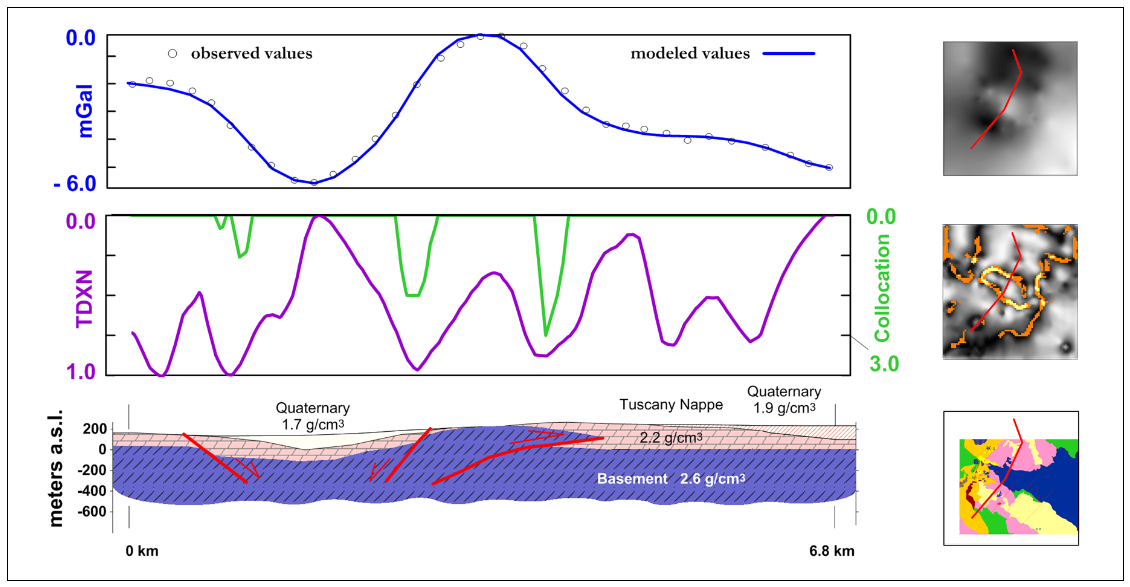

In [49]:
Fig3=io.imread('Figure3_big.png')

fig = plt.figure(figsize=(20, 14))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(Fig3)
plt.show()

### Future work - more edges

Gordon Cooper brought to my attention that the more recent tilt angle of the total horizontal derivative (THAG) gives much better results than the total horizontal derivative of the tilt angle (THDR).


Ferreira et al., 2013, Enhancement of the total horizontal gradient of magnetic anomalies using the tilt angle: Geophysics,78, no. 3

dx.doi.org/10.1190/geo2011-0441.1


### Future work - collocation matrix

...
...


### References

Cooper, G. R. J., and D. R. Cowan, 2006, Enhancing potential field data using filters based on the local phase: Computers & Geosciences, 32, no. 10, 1585–1591, http://dx.doi.org/10.1016/j.cageo.2006.02.016.

Cooper, G. R. J., and D. R. Cowan, 2008, Edge enhancement of potential-field data using normalized statistics: Geophysics, 73, no. 3, H1–H4, http://dx.doi.org/10.1190/1.2837309.

Niccoli, M., 2000, Gravity, magnetic, and geological exploration in the Monti Romani of southern Tuscany: Unpublished field and research thesis, University of Rome La Sapienza (in Italian).

Niccoli, M., 2012, Visualization tips for geoscientists: MATLAB, Part III: MyCarta, bit.ly/1BqGbHZ.

Pilkington, M., and P. Keating, 2004, Contact mapping from gridded magnetic data — A comparison of techniques: Exploration Geophysics, 35, no. 4, 306–311, http://dx.doi.org/10.1071/EG04306.

Pilkington, M., and P. Keating, 2010, Geologic applications of magnetic data and using enhancements for contact mapping: EGM 2010 International Workshop, bit.ly/1H9mbMo.

Russell, B. H., and C. Ribordy, 2014, New edge detection methods for seismic interpretation: CREWES Research Report, 67, no. 26.

Uieda, L., V. C. Oliveira Jr., A. Ferreira, H. B. Santos, and J. F. Caparica Jr., 2014, Fatiando a Terra: A Python package for modeling and inversion in geophysics: figshare, http://dx.doi.org/10.6084/m9.figshare.1115194.

van der Walt, S., J. L. Schönberger, J. Nunez-Iglesias, F. Boulogne, J. D. Warner, N. Yager, E. Gouillart, T. Yu, and the scikit-image contributors, 2014, scikit-image: Image processing in Python, http://dx.doi.org/10.7717/peerj.453.

Verduzco, B., J. D. Fairhead, C. M. Green, and C. MacKenzie, 2004, New insights into magnetic derivatives for structural mapping: The Leading Edge, 23, no. 2, 116–119, http://dx.doi.org/10.1190/1.1651454.